# Setting up the environment

To set up a conda environment with everything you need to run this notebook, go to the directory with the notebook in a shell on your computer and run the command:
```
mamba env create -n py310_aisem2023 -f environment.yml
```
If you don't have mamba installed, either start with:
```
conda install -c conda-forge mamba
```
and then run the `mamba env` command above or do:
```
conda env create -n py310_aisem2023 -f environment.yml
```
(but this last alternative will be considerably slower)


# Ok, let's start

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import rdkit
print(rdkit.__version__)

2022.09.5


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('tableau-colorblind10')

# Preparing a dataset to learn

Start easy with one of the data sets from yesterday

,compound_chembl_id,canonical_smiles,pchembl_value,standard_value,standard_units,standard_relation,standard_type,ROMol
0,CHEMBL1054,NS(=O)(=O)c1cc2c(cc1Cl)NC(C(Cl)Cl)NS2(=O)=O,7.04,91.0,nM,=,Ki,
1,CHEMBL1055,NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl,6.86,138.0,nM,=,Ki,
2,CHEMBL106848,NS(=O)(=O)c1ccc(SCCO)cc1,7.68,21.0,nM,=,Ki,
3,CHEMBL107217,CCN(CC)C(=S)[S-].[Na+],5.51,3100.0,nM,=,Ki,
4,CHEMBL1081233,CCCCC(CC)C(N)=O,5.46,3450.0,nM,=,Ki,

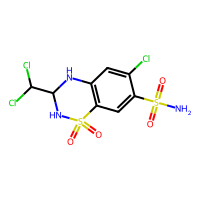
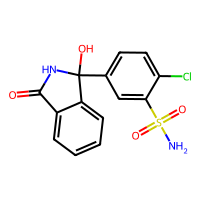
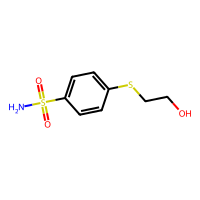
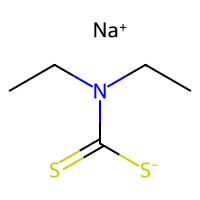
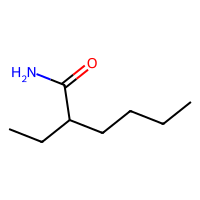

In [3]:
df = pd.read_csv('../Chemical_Data_Science/data/Ki_data/target_CHEMBL205.csv.gz')
PandasTools.AddMoleculeColumnToFrame(df,'canonical_smiles')
PandasTools.RenderImagesInAllDataFrames(True)
df.head()

Start by standardizing the molecules:

In [4]:
# The standardizer is very verbose... turn that off:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')
# and now standardize the molecules:
from rdkit.Chem.MolStandardize import rdMolStandardize
df['mol_parent'] = df.ROMol.map(rdMolStandardize.ChargeParent)

Now generate fingerprints

In [5]:
from rdkit.Chem import rdFingerprintGenerator

fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fps = [fpg.GetFingerprintAsNumPy(m) for m in df.mol_parent]

We're going to build a classification - i.e. active/inactive - model, so convert the pchembl_values to 1s and 0s by binning activity at 7 (corresponds Ki = 100 nM)

In [6]:
acts = [1 if x>=7 else 0 for x in df.pchembl_value]

In [7]:
len(acts),sum(acts)

(4511, 2662)

Now we need a training/test split. Scikit learn has tools for that:

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fps,
                                                    acts,
                                                    test_size=0.2,
                                                    random_state=0xf00d,
                                                    shuffle=True,
                                                    stratify=acts)

In [9]:
len(y_train),sum(y_train)

(3608, 2129)

Build a random forest with that. I have a standard set of hyperparameters that I use for this:

In [10]:
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(n_estimators=500,
                             max_depth=15,
                             oob_score=True,
                             random_state=0xf00d,
                             n_jobs=4)
cls.fit(X_train,y_train)

RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=4, oob_score=True,
                       random_state=61453)

Look at how we did.

Start with accuracy on the training set:

In [11]:
from sklearn import metrics
from scipy import stats

preds = cls.predict(X_train)
print(metrics.accuracy_score(y_train,preds))
print(metrics.confusion_matrix(y_train,preds))

0.8414634146341463
[[ 952  527]
 [  45 2084]]


In [12]:
print(metrics.cohen_kappa_score(y_train,preds))

0.6551338991043537


In [13]:
print(metrics.classification_report(y_train,preds))

              precision    recall  f1-score   support

           0       0.95      0.64      0.77      1479
           1       0.80      0.98      0.88      2129

    accuracy                           0.84      3608
   macro avg       0.88      0.81      0.82      3608
weighted avg       0.86      0.84      0.83      3608



Let's make a function for that:

In [15]:
def evaluate_model_performance(preds,probs,y):
    res = dict(confusion = metrics.confusion_matrix(y,preds),
        accuracy = metrics.accuracy_score(y,preds),
        kappa = metrics.cohen_kappa_score(y,preds),
        mcc = metrics.matthews_corrcoef(y,preds),
        auroc = metrics.roc_auc_score(y,probs[:,1]),
        report = metrics.classification_report(y,preds))
    return res
    
def show_model_performance(preds,probs,y):
    perf = evaluate_model_performance(preds,probs,y)
    output = f'''
Accuracy: {perf['accuracy']:.3f} Kappa: {perf['kappa']:.3f} MCC: {perf['mcc']:.3f} AUROC: {perf['auroc']:.3f}
Confusion matrix:
{perf['confusion']}
Report:
{perf['report']}
'''
    print(output)

In [16]:
preds = cls.predict(X_train)
probs = cls.predict_proba(X_train)
show_model_performance(preds,probs,y_train)


Accuracy: 0.841 Kappa: 0.655 MCC: 0.685 AUROC: 0.954
Confusion matrix:
[[ 952  527]
 [  45 2084]]
Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77      1479
           1       0.80      0.98      0.88      2129

    accuracy                           0.84      3608
   macro avg       0.88      0.81      0.82      3608
weighted avg       0.86      0.84      0.83      3608




Now for the test set:

In [17]:
preds = cls.predict(X_test)
probs = cls.predict_proba(X_test)
show_model_performance(preds,probs,y_test)


Accuracy: 0.786 Kappa: 0.530 MCC: 0.566 AUROC: 0.880
Confusion matrix:
[[202 168]
 [ 25 508]]
Report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       370
           1       0.75      0.95      0.84       533

    accuracy                           0.79       903
   macro avg       0.82      0.75      0.76       903
weighted avg       0.81      0.79      0.77       903




And finally for the out-of-bag predictions:

In [18]:
preds = [1 if x>=0.5 else 0 for x in cls.oob_decision_function_[:,1]]
probs = cls.oob_decision_function_
show_model_performance(preds,probs,y_train)


Accuracy: 0.779 Kappa: 0.517 MCC: 0.544 AUROC: 0.869
Confusion matrix:
[[ 822  657]
 [ 141 1988]]
Report:
              precision    recall  f1-score   support

           0       0.85      0.56      0.67      1479
           1       0.75      0.93      0.83      2129

    accuracy                           0.78      3608
   macro avg       0.80      0.74      0.75      3608
weighted avg       0.79      0.78      0.77      3608




Another very useful assessment of model performance is to look at the ROC curve:

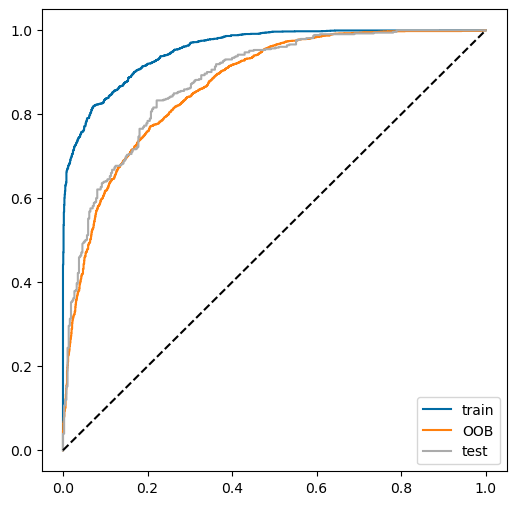

In [19]:
plt.figure(figsize=(6,6))
train_probs = cls.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, train_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='train');

oob_probs = cls.oob_decision_function_
fpr, tpr, thresholds = metrics.roc_curve(y_train, oob_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='OOB');

test_probs = cls.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='test');

plt.plot((0,1),(0,1),'k--')
plt.legend();

Both our training/test split and model training involve random numbers, so we really should repeat them multiple times and collect statistics instead of just looking at a single value.

Let's get a sense of how much of a difference that makes.

Start with looking at the variability of the random forest results:

In [20]:
rf_accum = []
for i in range(10):
    cls = RandomForestClassifier(n_estimators=500,
                                 max_depth=15,
                                 oob_score=True,
                                 random_state=0xf00d+i,
                                 n_jobs=4)
    cls.fit(X_train,y_train)
    preds = cls.predict(X_test)
    probs = cls.predict_proba(X_test)
    rf_accum.append(evaluate_model_performance(preds,probs,y_test))

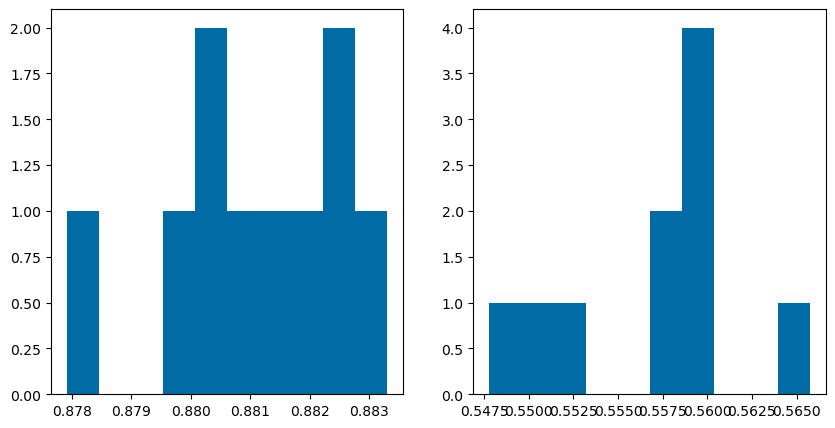

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist([x['auroc'] for x in rf_accum]);
plt.subplot(1,2,2)
plt.hist([x['mcc'] for x in rf_accum]);

In [22]:
for metric in ('accuracy','kappa','mcc','auroc'):
    print(f'{metric}: {np.median([x[metric] for x in rf_accum]):.3f} +/- {stats.median_abs_deviation([x[metric] for x in rf_accum]):.3f}')

accuracy: 0.783 +/- 0.001
kappa: 0.522 +/- 0.002
mcc: 0.558 +/- 0.001
auroc: 0.881 +/- 0.001


That's not a lot of variability. How much of a difference does the data split make?

In [23]:
split_accum = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(fps,
                                                        acts,
                                                        test_size=0.2,
                                                        random_state=0xf00d+i,
                                                        shuffle=True,
                                                        stratify=acts)
    cls = RandomForestClassifier(n_estimators=500,
                                 max_depth=15,
                                 oob_score=True,
                                 random_state=0xf00d+i,
                                 n_jobs=4)
    cls.fit(X_train,y_train)
    preds = cls.predict(X_test)
    probs = cls.predict_proba(X_test)
    split_accum.append(evaluate_model_performance(preds,probs,y_test))

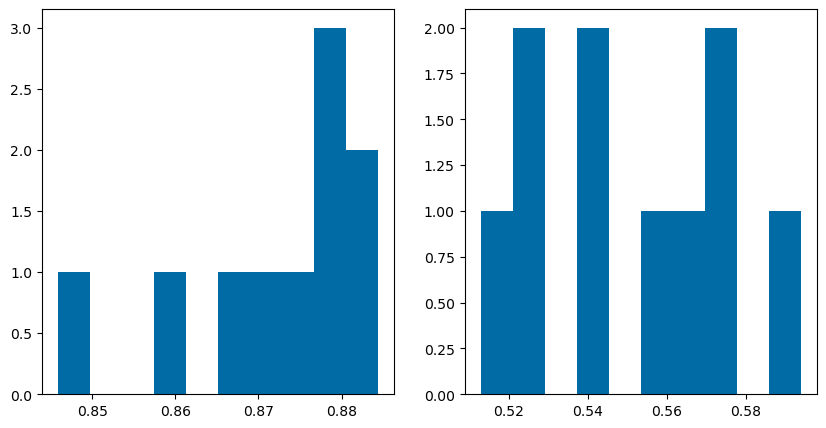

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist([x['auroc'] for x in split_accum]);
plt.subplot(1,2,2)
plt.hist([x['mcc'] for x in split_accum]);

In [25]:
for metric in ('accuracy','kappa','mcc','auroc'):
    print(f'{metric}: {np.median([x[metric] for x in split_accum]):.3f} +/- {stats.median_abs_deviation([x[metric] for x in split_accum]):.3f}')

accuracy: 0.780 +/- 0.009
kappa: 0.519 +/- 0.018
mcc: 0.548 +/- 0.023
auroc: 0.876 +/- 0.005


That's about an order of magnitude more variation, but it's still not horrible in this case.

I *always* check the variability with the data split and often check it with the random forest split as well.

# Exercise

In [26]:
df = pd.read_csv('./data/chembl_cyps.tsv.gz',sep='\t')
df.head()

,assay_id,doc_id,description,assay_organism,assay_chembl_id,pref_name,activity_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,pchembl_value,standard_inchi_key,canonical_smiles,compound_chembl_id,Iteration
0,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986597,778799,=,7943.28,nM,1,AC50,5.10,RJXCYVJLXGRCHK-UHFFFAOYSA-N,Fc1cccc(c1)C(=O)N2CCC3(CCN(Cc4ccccc4)CC3)CC2,CHEMBL1354915,0
1,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986598,878902,=,10000.00,nM,1,AC50,5.00,CFLWEGVGTKRSKY-UHFFFAOYSA-N,CN(C)C(=O)c1ccc(cc1)c2ccc3ncnc(Nc4ccc(F)cc4)c3c2,CHEMBL1455018,0
2,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986599,766975,=,22387.21,nM,1,AC50,4.65,BLYSRVMJHGAIMN-UHFFFAOYSA-N,CCCCn1nc2cc(ccc2c1OCC)C(=O)NC3CCCc4ccccc34,CHEMBL1343091,0
3,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986600,882987,=,15848.93,nM,1,AC50,4.80,RGBSTAYYVOCRDD-UHFFFAOYSA-N,CCOc1c2ccc(cc2nn1CCOC)C(=O)NCc3ccc4OCOc4c3,CHEMBL1459103,0
4,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986601,761292,=,2238.72,nM,1,AC50,5.65,WEANVNPBBLEIIO-UHFFFAOYSA-N,COc1ccc(NC(=O)CSc2nc(C)c3CCCCc3c2C#N)cc1,CHEMBL1337408,0


In [27]:
df_2d6 = df[df.assay_chembl_id=='CHEMBL1741321']
len(df_2d6)

5680

In [28]:
PandasTools.AddMoleculeColumnToFrame(df_2d6,'canonical_smiles')

C:\Users\glandrum\mambaforge\envs\py310_aisem2023\lib\site-packages\rdkit\Chem\PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


See that warning? Do **not** ignore it.
The right thing to do is this:

In [29]:
df_2d6 = df[df.assay_chembl_id=='CHEMBL1741321'].copy()
PandasTools.AddMoleculeColumnToFrame(df_2d6,'canonical_smiles')
len(df_2d6)

5680

,assay_id,doc_id,description,assay_organism,assay_chembl_id,pref_name,activity_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,pchembl_value,standard_inchi_key,canonical_smiles,compound_chembl_id,Iteration,ROMol
0,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986597,778799,=,7943.28,nM,1,AC50,5.10,RJXCYVJLXGRCHK-UHFFFAOYSA-N,Fc1cccc(c1)C(=O)N2CCC3(CCN(Cc4ccccc4)CC3)CC2,CHEMBL1354915,0,
1,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986598,878902,=,10000.00,nM,1,AC50,5.00,CFLWEGVGTKRSKY-UHFFFAOYSA-N,CN(C)C(=O)c1ccc(cc1)c2ccc3ncnc(Nc4ccc(F)cc4)c3c2,CHEMBL1455018,0,
2,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986599,766975,=,22387.21,nM,1,AC50,4.65,BLYSRVMJHGAIMN-UHFFFAOYSA-N,CCCCn1nc2cc(ccc2c1OCC)C(=O)NC3CCCc4ccccc34,CHEMBL1343091,0,
3,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986600,882987,=,15848.93,nM,1,AC50,4.80,RGBSTAYYVOCRDD-UHFFFAOYSA-N,CCOc1c2ccc(cc2nn1CCOC)C(=O)NCc3ccc4OCOc4c3,CHEMBL1459103,0,
4,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986601,761292,=,2238.72,nM,1,AC50,5.65,WEANVNPBBLEIIO-UHFFFAOYSA-N,COc1ccc(NC(=O)CSc2nc(C)c3CCCCc3c2C#N)cc1,CHEMBL1337408,0,

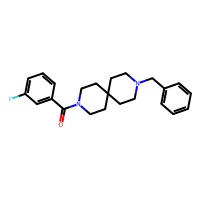
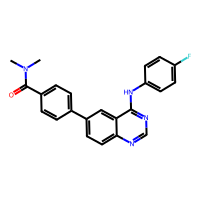
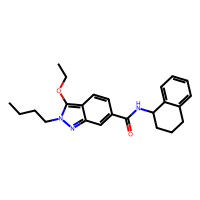
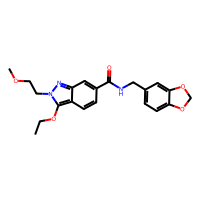
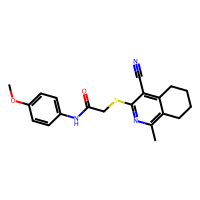

In [30]:
PandasTools.RenderImagesInAllDataFrames(True)
df_2d6.head()

In [31]:
df_2d6['mol_parent'] = df_2d6.ROMol.map(rdMolStandardize.ChargeParent)

In [32]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fps = [fpg.GetFingerprintAsNumPy(m) for m in df_2d6.mol_parent]

What are we going to use for an activity bin?

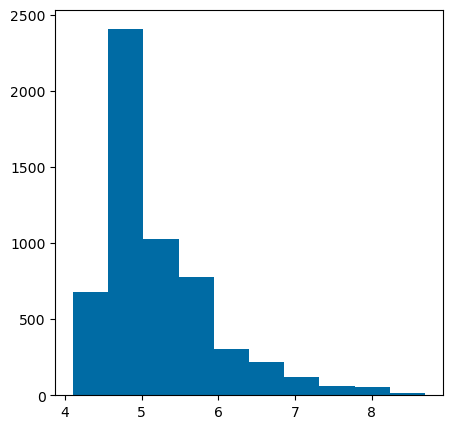

In [33]:
plt.figure(figsize=(5,5))
plt.hist(df_2d6.pchembl_value);

Let's try pchembl_value=6

In [34]:
acts = [1 if x>=6 else 0 for x in df_2d6.pchembl_value]
len(acts),sum(acts)

(5680, 748)

This dataset is imbalanced!

Let's try one model and see what we get:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(fps,
                                                    acts,
                                                    test_size=0.2,
                                                    random_state=0xf00d,
                                                    shuffle=True,
                                                    stratify=acts)
cls = RandomForestClassifier(n_estimators=500,
                             max_depth=15,
                             oob_score=True,
                             random_state=0xf00d,
                             n_jobs=4)
cls.fit(X_train,y_train)
test_preds = cls.predict(X_test)
test_probs = cls.predict_proba(X_test)
show_model_performance(test_preds,test_probs,y_test)


Accuracy: 0.871 Kappa: 0.053 MCC: 0.135 AUROC: 0.716
Confusion matrix:
[[984   2]
 [145   5]]
Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       986
           1       0.71      0.03      0.06       150

    accuracy                           0.87      1136
   macro avg       0.79      0.52      0.50      1136
weighted avg       0.85      0.87      0.82      1136




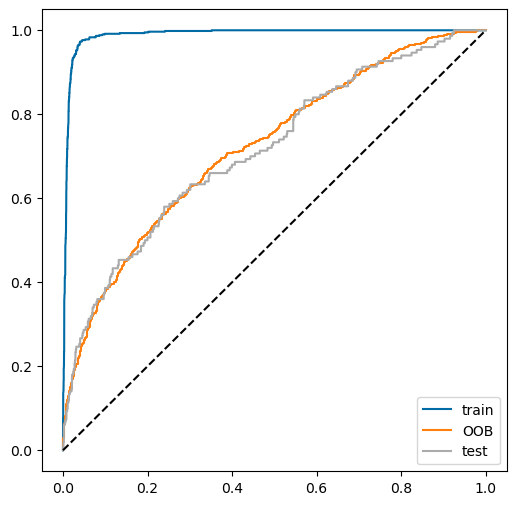

In [36]:
plt.figure(figsize=(6,6))
train_probs = cls.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, train_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='train');

oob_probs = cls.oob_decision_function_
fpr, tpr, thresholds = metrics.roc_curve(y_train, oob_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='OOB');

test_probs = cls.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='test');

plt.plot((0,1),(0,1),'k--')
plt.legend();

Digression to talk about the impact of imbalance on machine learning performance

Variability:

In [37]:
split_accum = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(fps,
                                                        acts,
                                                        test_size=0.2,
                                                        random_state=0xf00d+i,
                                                        shuffle=True,
                                                        stratify=acts)
    cls = RandomForestClassifier(n_estimators=500,
                                 max_depth=15,
                                 oob_score=True,
                                 random_state=0xf00d+i,
                                 n_jobs=4)
    cls.fit(X_train,y_train)
    preds = cls.predict(X_test)
    probs = cls.predict_proba(X_test)
    split_accum.append(evaluate_model_performance(preds,probs,y_test))

for metric in ('accuracy','kappa','mcc','auroc'):
    print(f'{metric}: {np.median([x[metric] for x in split_accum]):.3f} +/- {stats.median_abs_deviation([x[metric] for x in split_accum]):.3f}')

accuracy: 0.873 +/- 0.001
kappa: 0.075 +/- 0.016
mcc: 0.178 +/- 0.022
auroc: 0.714 +/- 0.014


Not a lot of variability. That's good!

In [38]:
from xgboost import XGBClassifier
cls = XGBClassifier(max_depth=3,
                         n_estimators=300,
                         random_state=0xf00d,
                         n_jobs=4)
cls.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=4, num_parallel_tree=None,
              predictor=None, random_state=61453, ...)

In [39]:
preds = cls.predict(X_test)
probs = cls.predict_proba(X_test)
show_model_performance(preds,probs,y_test)


Accuracy: 0.876 Kappa: 0.242 MCC: 0.288 AUROC: 0.686
Confusion matrix:
[[966  20]
 [121  29]]
Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       986
           1       0.59      0.19      0.29       150

    accuracy                           0.88      1136
   macro avg       0.74      0.59      0.61      1136
weighted avg       0.85      0.88      0.85      1136




In [40]:
split_accum = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(fps,
                                                        acts,
                                                        test_size=0.2,
                                                        random_state=0xf00d+i,
                                                        shuffle=True,
                                                        stratify=acts)
    cls = XGBClassifier(max_depth=3,
                         n_estimators=300,
                         random_state=0xf00d+i,
                         n_jobs=4)
    cls.fit(X_train,y_train)
    preds = cls.predict(X_test)
    probs = cls.predict_proba(X_test)
    split_accum.append(evaluate_model_performance(preds,probs,y_test))

for metric in ('accuracy','kappa','mcc','auroc'):
    print(f'{metric}: {np.median([x[metric] for x in split_accum]):.3f} +/- {stats.median_abs_deviation([x[metric] for x in split_accum]):.3f}')

accuracy: 0.871 +/- 0.003
kappa: 0.193 +/- 0.025
mcc: 0.232 +/- 0.025
auroc: 0.702 +/- 0.016


## Additional tasks to try

Some things you might try:

1. Try other model hyperparemters: number of trees, tree depth, etc (look at the scikit-learn docs for more) and see if those make a difference.
1. Try other fingerprints (RDKit FP, topological torsion, atom pair, look at atom counts, fingerprint lengths, etc.) and see if they make a difference. Here's a tutorial for the fingerprint generator: https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html
2. Try one or more of the other assays (CYP targets) in the input file. Do you see differences in predictive performance?
3. Try finding the set of compounds which have been tested against all of the CYPs (we did something like this yesterday) and build a model to predict whether or not a particular compound is selective for a particular CYP (i.e. is active against that CYP but not any of the others).
4. Try using logistic regression as the model type and see how it performs relative to random forests and XGB?
5. Try using a vector of descriptors instead of a fingerprint. How well does that perform? Here's a tutorial for descriptor calculation: https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html
6. Look in the online version of ChEMBL and see if you can find additional compounds for CYP 2D6. See how well the models built above perform on those external validation compounds. **Note** that we have to be quite careful here because comparing IC50/AC50/EC50/etc values between different assays is generally unreliable


# Very, very, very important note

In this exercise we have not actually done real validation of our model: we've used the whole dataset as we've tried different algorithms, fingerprints, hyperparameters, etc.

If you want to know if the model actually works, you need to try it on a set of data that it hasn't seen before in any way.